# for meanNN entorpy

In [1]:
import torch
import numpy as np
import cv2
# import scipy

from torch import nn
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group
from scipy.spatial import distance

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import ica

from modules.util import entropy,entropyLoss, getdata, infomaxICA




In [2]:
np.random.seed(1005)
n_dist = 10
# numbatch=100
# batchsize = int(35000/numbatch)
sub_shape = n_dist

A = np.random.rand(n_dist,n_dist)
# A = np.random.normal(0, 1,(n_dist,n_dist))
# D = np.diag(np.array([1,100,200,300,400,500,600,700,800,900], dtype=float))

# B = ortho_group.rvs(dim=n_dist)
# A = B @ D
print('condition number:', np.linalg.cond(A))
X_list = []
# X_list.append(np.random.standard_t(5, size=(1,16384)))
# X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
# X_list.append(np.random.exponential(scale, size=(1,16384)))
for i in range(n_dist):
    scale = np.random.randint(5,15)
#     print(scale)
#     X_list.append(np.random.beta(0.5,0.5,(1,16384)))
#     X_list.append(np.random.randn(1, 35000))
    X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
#     X_list.append(np.random.standard_t(1, size=(1,16384)))
#     X_list.append(np.random.exponential(scale, size=(1,16384)))
#     X_list.append(np.random.chisquare(scale, size=(1,16384)))
    
dist_c = np.concatenate(X_list)


# unif = np.random.uniform(1,2,(10,numbatch))
# for i in range(numbatch):
#     dist_c[:,batchsize*i:batchsize*(i+1)] *= unif[:,i:i+1]

Mixture = A@dist_c



condition number: 296.3259474477134


In [3]:
# plt.figure(figsize=(10,10))



# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(dist_c[i, :], dist_c[j, :], '.', ms=1)
# #         plt.axis('square')

In [4]:
# plt.figure(figsize=(10,10))
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(Mixture[i, :], Mixture[j, :], '.', ms=1)

In [5]:

IPT = torch.from_numpy(Mixture).type(torch.float32)
# IPT = (IPT - IPT.mean(axis=1).unsqueeze(1))/(IPT.std(axis=1, unbiased=False).unsqueeze(1))
# IPT = (IPT-IPT.min(1).values.unsqueeze(1))/(IPT.max(1).values - IPT.min(1).values).unsqueeze(1)

# # data whitening
x_white, white, dewhite = ica.pca_whiten(Mixture, n_dist)
IPT = torch.from_numpy(x_white.copy()).type(torch.float32)
# IPT = torch.from_numpy(IPT).type(torch.float32)

In [6]:
# plt.figure(figsize=(10,10))



# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(x_white[i, :], x_white[j, :], '.', ms=1)
# #         plt.axis('square')

In [7]:
# plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
# plt.title('mixture input after whitening')
# plt.axis('square')
# plt.grid()

In [8]:
device = torch.device('cuda:0')

In [9]:
model = infomaxICA(n_dist)

In [10]:
learning_rate = 0.003 / np.log(n_dist)
# batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
batch_size = 64

# batch_size=4000

dataset = getdata(IPT)
# sampler =RandomSampler(dataset)
sampler = SequentialSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)


# optimizer = torch.optim.SGD(model.parameters(),lr=2.5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
#                              eps=10e-4,
#                              weight_decay = 1e-3,
                            )

num_epoch = 500
scheduler = OneCycleLR(optimizer, 0.01, steps_per_epoch=len(loader), epochs=num_epoch)

# np.linalg.inv(model.W2.weight.data)

In [11]:
model = model.to(device)
IPT = IPT.to(device)

In [12]:
loss_tracker = []

In [13]:
def angle2cart(a):
    # a should be in shape [t,d], d for number of dimensions, t for number of pixels
    d = a.shape[1]
    t = a.shape[0]

    r = [1]+[10*2**i for i in range(d-1)] # radii

    multi_sin = torch.sin(a)
    multi_tan = torch.tan(a)

    output = r[0] * multi_sin[:, 0:1] #for x1
    for j in range(1, d): #for x2 to xn
        output = torch.cat((output, (output[:,-1:]/multi_tan[:,j-1:j] + r[j]) * multi_sin[:, j:(j+1)]), 1)
    output = torch.cat((output, output[:, -1:] / multi_tan[:,-1:]), 1)  #for xn+1

    return output

In [14]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


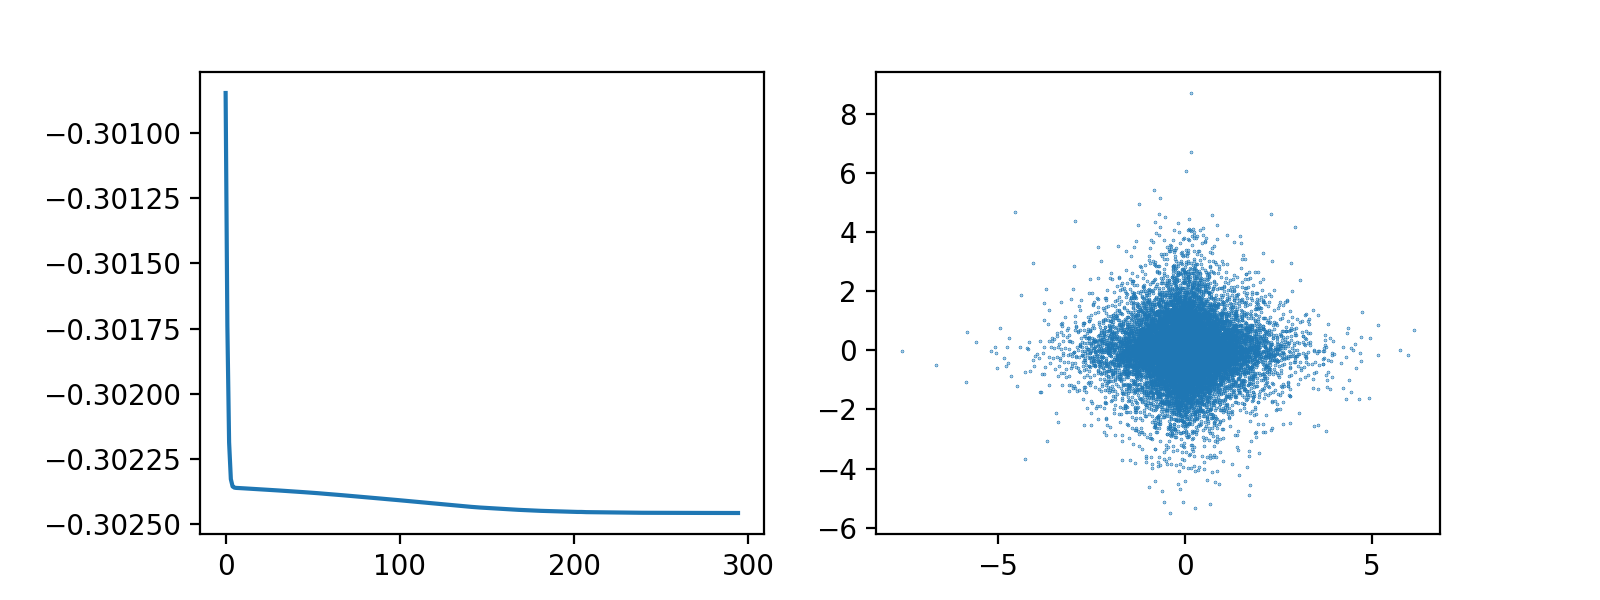

lr changed to: 0.0011725951011387799
1 tensor(90.) -0.3008480668067932 tensor(0.3579, device='cuda:0')
2 tensor(32.2699) -0.30173933506011963 tensor(0.2152, device='cuda:0')
3 tensor(48.8901) -0.30218565464019775 tensor(0.0977, device='cuda:0')
4 tensor(54.1887) -0.30232641100883484 tensor(0.0237, device='cuda:0')
5 tensor(57.3965) -0.3023543059825897 tensor(0.0045, device='cuda:0')
lr changed to: 0.0010553355910249019
6 tensor(61.4872) -0.30235880613327026 tensor(0.0009, device='cuda:0')
7 tensor(26.4894) -0.302359938621521 tensor(0.0003, device='cuda:0')
8 tensor(46.9690) -0.3023603856563568 tensor(0.0002, device='cuda:0')
9 tensor(57.6889) -0.30236074328422546 tensor(0.0002, device='cuda:0')
10 tensor(59.5394) -0.30236101150512695 tensor(0.0002, device='cuda:0')
lr changed to: 0.0009498020319224117
11 tensor(61.7642) -0.30236127972602844 tensor(0.0002, device='cuda:0')
12 tensor(5.2952) -0.3023618161678314 tensor(0.0002, device='cuda:0')
13 tensor(5.3281) -0.30236220359802246 tensor

114 tensor(23.7178) -0.30241525173187256 tensor(0.0004, device='cuda:0')
115 tensor(24.6490) -0.3024161159992218 tensor(0.0004, device='cuda:0')
116 tensor(25.6335) -0.3024166524410248 tensor(0.0004, device='cuda:0')
117 tensor(26.1942) -0.30241724848747253 tensor(0.0004, device='cuda:0')
118 tensor(27.1922) -0.30241790413856506 tensor(0.0004, device='cuda:0')
119 tensor(28.0572) -0.30241867899894714 tensor(0.0004, device='cuda:0')
120 tensor(29.1594) -0.3024192154407501 tensor(0.0004, device='cuda:0')
121 tensor(30.2205) -0.30241984128952026 tensor(0.0004, device='cuda:0')
122 tensor(31.3709) -0.30242040753364563 tensor(0.0004, device='cuda:0')
123 tensor(31.8538) -0.30242103338241577 tensor(0.0004, device='cuda:0')
124 tensor(32.6642) -0.30242177844047546 tensor(0.0004, device='cuda:0')
125 tensor(33.6741) -0.3024224638938904 tensor(0.0004, device='cuda:0')
126 tensor(34.3560) -0.3024230897426605 tensor(0.0004, device='cuda:0')
127 tensor(35.5604) -0.3024238049983978 tensor(0.0004, d

226 tensor(29.2688) -0.3024543523788452 tensor(4.3761e-05, device='cuda:0')
227 tensor(30.4275) -0.3024543821811676 tensor(4.1962e-05, device='cuda:0')
228 tensor(30.4977) -0.30245450139045715 tensor(4.1712e-05, device='cuda:0')
229 tensor(31.2256) -0.30245450139045715 tensor(4.0968e-05, device='cuda:0')
230 tensor(31.6840) -0.3024545907974243 tensor(3.7928e-05, device='cuda:0')
231 tensor(30.9635) -0.3024546205997467 tensor(3.6896e-05, device='cuda:0')
232 tensor(31.6978) -0.3024546802043915 tensor(3.6042e-05, device='cuda:0')
233 tensor(31.0264) -0.30245473980903625 tensor(3.4909e-05, device='cuda:0')
234 tensor(31.9523) -0.30245473980903625 tensor(3.3384e-05, device='cuda:0')
235 tensor(32.9145) -0.3024548590183258 tensor(3.2272e-05, device='cuda:0')
236 tensor(32.9077) -0.3024548292160034 tensor(3.1792e-05, device='cuda:0')
237 tensor(33.7160) -0.30245500802993774 tensor(2.9281e-05, device='cuda:0')
238 tensor(35.3131) -0.30245503783226013 tensor(2.8024e-05, device='cuda:0')
239 te

KeyboardInterrupt: 

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax2 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-8
d_weigths = torch.zeros(n_dist)
old_d_weights = torch.zeros([1, n_dist])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(100):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
#         opt = angle2cart(opt)
#                 opt = spher2cart(opt)
    
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
        loss = entropy(opt, k=3, dis=1)
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 1 == 0:
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
        data = model.forward(IPT.T).cpu().detach().numpy()
#         data = model.forward(IPT.T)
#         data2 = angle2cart(data).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()

        ax1.clear()
        ax1.plot(data[:, 0], data[:, 1], '.', ms=0.5)
        fig.canvas.draw()
#         ax1.clear()
# #         ax1.plot(data2[:, 0], data2[:, 1], '.', ms=0.5)
        

#         ax1.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

#         ax1.set_xlim3d(-10,10)
#         ax1.set_ylim3d(-10,10)
#         ax1.set_zlim3d(-10,10)
        
#         fig.canvas.draw()
        
#         data2 = (model.W2.weight.data@IPT).cpu().detach().numpy().T
#         xR = np.corrcoef(data2.T, rowvar=True)
# #         trace.append(data[300,:])
# #         trace.append(data2[:,100])
#         ax2.clear()
#         ax2.imshow(np.abs(xR), cmap='gist_heat')
# #         ax2.plot(data2.T[:, 0], data2.T[:, 2], '.', ms=0.5)
#         fig.canvas.draw()
    

    step0 += 1
    print(step0, angle_delta, LOSS.detach().numpy()/len(loader.sampler), change)
    scheduler.step()

In [16]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = data2[:, -1]
# xline = data2[:, -2]
# yline = data2[:, -3]

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

In [17]:
model = model.cpu()
mixture = IPT.cpu()

data_mnn = model.W1.weight.data @ mixture

scale = data_mnn.std(axis=1).reshape((-1, 1))
data_mnn = data_mnn / scale

# data_opt = model.forward(mixture.T).cpu().detach().numpy()
# plt.imshow(np.abs(np.corrcoef(data_opt.T)), cmap='gist_heat')

In [18]:
# plt.figure(figsize=(10,10))

# sub_shape = n_dist

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(Mixture[i], Mixture[j], '.', ms=1)
#         plt.axis('square')

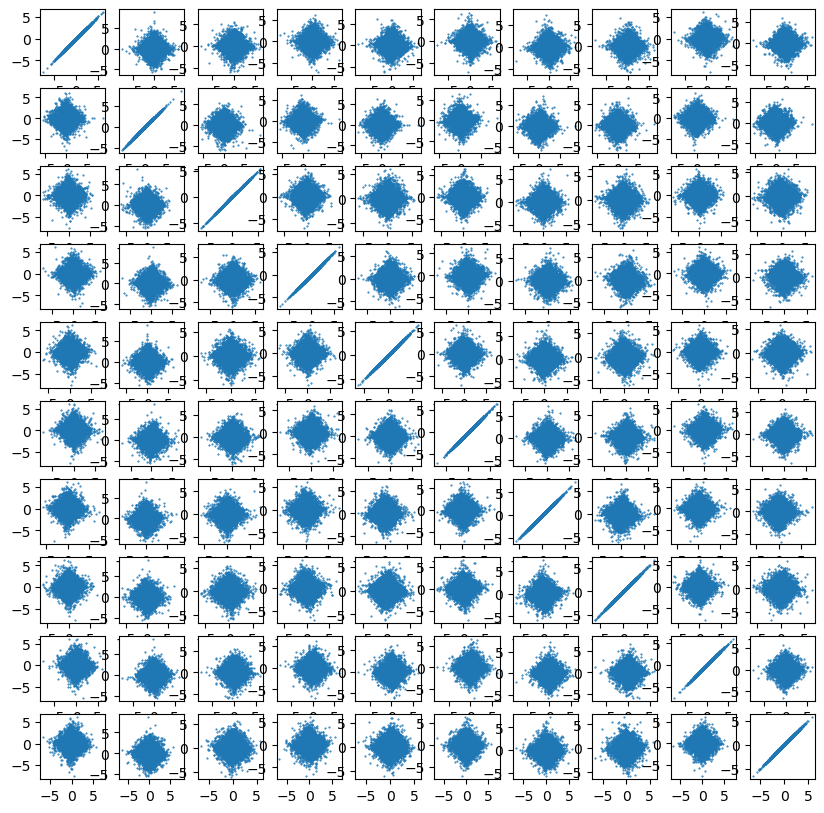

In [19]:
%matplotlib inline
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data_mnn[i], data_mnn[j], '.', ms=1)
        plt.axis('square')

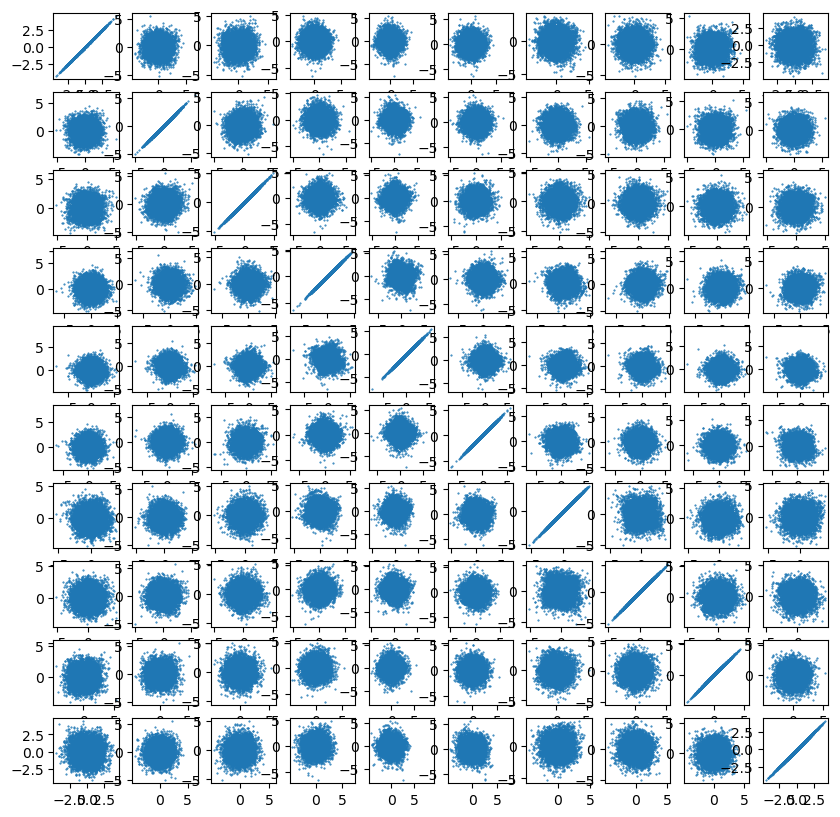

In [20]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(x_white[i], x_white[j], '.', ms=1)
        plt.axis('square')

In [20]:
# %matplotlib inline
# plt.figure(figsize=(4,10))

# plt.subplot(3,1,1)
# plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
# plt.title('mixture input after whitening')
# plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_mnn.T[:,0], data_mnn.T[:,1], '.', ms=0.1)
# plt.title('output without sigmoid')
# # plt.xlim([-5, 5])
# # plt.ylim([-5, 5])
# plt.axis('square')
# plt.grid()

# # plot of the original laplace
# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('ground truth')
# plt.axis('square')
# plt.grid()

In [21]:
# %matplotlib inline
# xR = np.corrcoef(dist_c, data2.T, rowvar=True)
# plt.imshow(np.abs(xR), cmap='gist_heat')

In [22]:
# plt.figure(figsize=(10,10))

# sub_shape = n_dist

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data[:, i], data[:, j], '.', ms=0.1)
#         plt.axis('square')

In [23]:
# %matplotlib inline
# plt.figure(figsize=(4,10))

# plt.subplot(3,1,1)
# plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
# plt.title('mixture input after whitening')
# plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_mnn.T[:,0], data_mnn.T[:,1], '.', ms=0.1)
# plt.title('output without sigmoid')
# # plt.xlim([-5, 5])
# # plt.ylim([-5, 5])
# plt.axis('square')
# plt.grid()

# # plot of the original laplace
# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('ground truth')
# plt.axis('square')
# plt.grid()

# infomax

In [21]:
A0, data_infomax, W = ica.ica1(Mixture, n_dist, verbose=True)

Whitening data...
x_white shape: 10, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 59: Lrate 5.4e-06,Wchange 8.7e-07,Angle 100.86
Done.


In [25]:
# def loss(x):
#     dim = x.shape[0]
#     nvox = x.shape[1]
#     entropy_loss = 0
#     for i in range(dim):
#         for j in range(i+1,dim):
#             dis = torch.sqrt(torch.sum((x[i]-x[j])**2))
#             entropy_loss += torch.log(dis)  
#     return dim/(nvox*(nvox-1))*entropy_loss
# print(loss(torch.from_numpy(data_infomax)))
# print(loss(data_mnn))

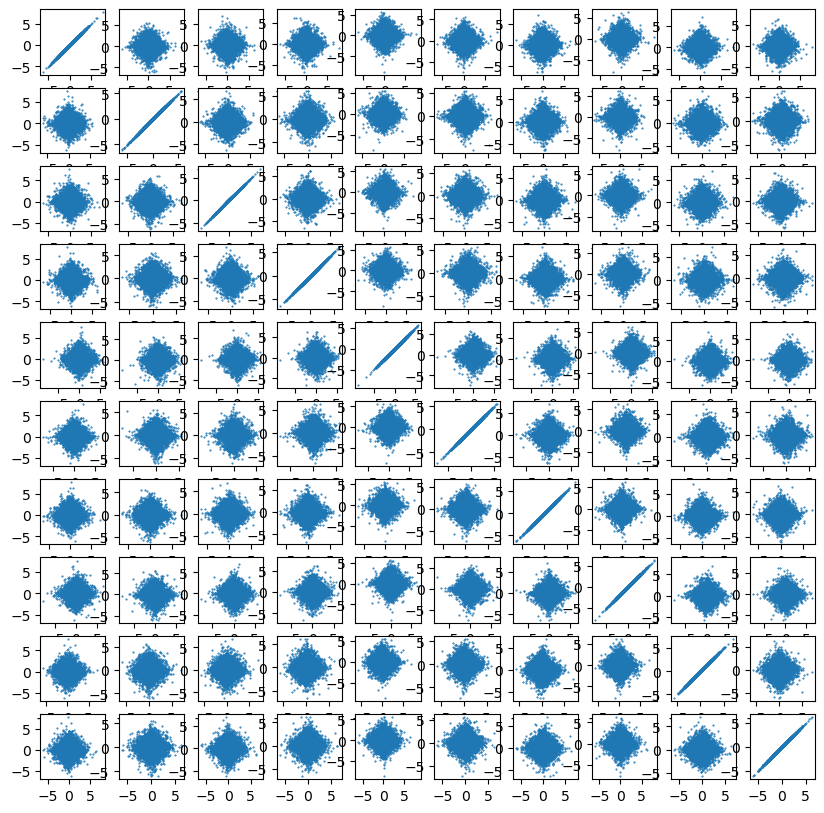

In [22]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data_infomax.T[:, i], data_infomax.T[:, j], '.', ms=1)
        plt.axis('square')

In [23]:
maps = np.corrcoef(data_mnn.detach().numpy(), data_infomax)

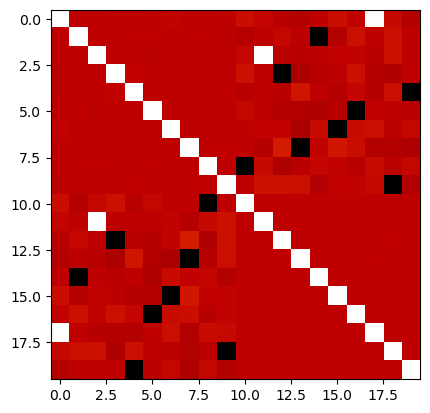

In [25]:
plt.imshow(maps, cmap='gist_heat')

In [ ]:
# def MISI(W,A,S):

#     WA = [W[cc] @ A[cc] for cc in range(len(W))]
    
#     M = len(S)
#     K = S[0].shape[0]

#     WAr = np.zeros((K,K))

#     for mm in range(M):
#         print(mm)
#         mk = np.split(S[mm] == 1, K, axis=0)
#         for kr in range(K):        # rows
#             mkr = mk[kr]
#             for kc in range(K):    # columns
#                 mkc = mk[kc]
#                 WAr[kr,kc] += np.abs(WA[mm][mkr.T @ mkc]).sum()
  
#     out = myISI(WAr)

#     return out, WAr

# def myISI(WAr):
#     N = WAr.shape[0]
#     WAr = np.abs(WAr)
#     ISI = 0.
#     ISI += np.sum(np.sum(WAr,axis=1)/np.max(WAr,axis=1) - 1)
#     # np.max(WAr,axis=1)
#     ISI += np.sum(np.sum(WAr,axis=0)/np.max(WAr,axis=0) - 1)
#     # np.max(WAr,axis=0)
#     ISI = ISI/(2*N*(N-1))
#     return ISI

In [ ]:
# w_mnn = model.W2.weight.data.detach().numpy()
# myISI(w_mnn*W)

In [ ]:
# plt.figure(figsize=(4,12))

# plt.subplot(3,1,1)
# plt.plot(Mixture[0,:], Mixture[1,:], '.', ms=1)
# plt.title('mixture input')
# # plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_infomax.T[:,0], data_infomax.T[:,1], '.', ms=0.1)
# plt.title('output')
# plt.axis('square')
# plt.grid()

# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('mixture input')
# plt.axis('square')
# plt.grid()

In [ ]:
# plt.figure(figsize=(9,3))

# plt.subplot(1,3,1)
# plt.plot(data_mnn.T[:,0], data_mnn.T[:,1], '.', ms=1)
# plt.title('my model')
# plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(1,3,2)
# plt.plot(data_fastica[:,0], data_fastica[:,1], '.', ms=1)
# plt.title('fastICA')
# plt.axis('square')
# plt.grid()

# plt.subplot(1,3,3)
# plt.plot(data_infomax.T[:,0], data_infomax.T[:,1], '.', ms=1)
# plt.title('infomax')
# plt.axis('square')
# plt.grid()